In [1]:
## mount drive to work with data and colab notebook in our drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#works for varsha
%cd /content/gdrive/My Drive/IITB_assignments/AML_project/Machine Learning/gender_recognition/dataset_gender/

#works for samarth
# %cd /content/gdrive/My Drive/Machine Learning/gender_recognition/dataset_gender/

/content/gdrive/.shortcut-targets-by-id/1ocdgOtleRoghSHNRCchwESlB5FSWMo76/Machine Learning/gender_recognition/dataset_gender


In [ ]:
train_img_path = 'Training'
val_img_path = 'Validation'

In [ ]:
!pip install scikit-plot --quiet

In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
img_width, img_height, img_depth = 150, 150, 1
num_classes = 2

---
> ImageDataGenerator is used to augment the data by applying any random transformations on each training image
as it is passed to the model. This will make the model robust and also save up on the overhead memory

---

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_img_path,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='binary',
    color_mode ="grayscale")
validation_generator = test_datagen.flow_from_directory(
    val_img_path,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='binary',
    color_mode ="grayscale")


Found 29051 images belonging to 2 classes.
Found 5846 images belonging to 2 classes.


---
> MODEL
---
> 

*  Activation function - ELU

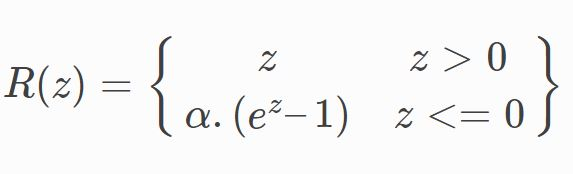

*  Kernel initializer - 'he_normal'. It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor. This is used when activation function is ReLU and it's variants. 

---



In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='binary_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

---
> Callback - A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). Two Callbacks used are
* Early stopping - Monitors the performance of the model for every epoch on a held-out validation set during the training, and terminates the training conditional on the validation performance. This prevents overfitting
* ReduceLROnPlateau - Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

---


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

---
> Optimiser - Adam. It can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.
---

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 80
optims = [optimizers.Adam(0.001)]
model = build_net(optims[0]) 
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch= 29051 / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 150, 150, 64)      256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       73856  

In [ ]:
#saving the model weights
model_yaml = model.to_yaml()
with open("model_gender.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_gender.h5")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

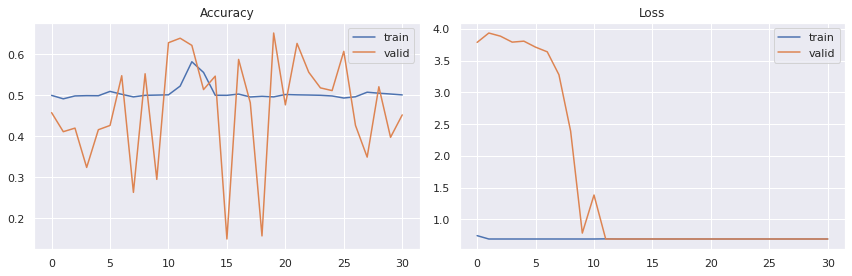

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

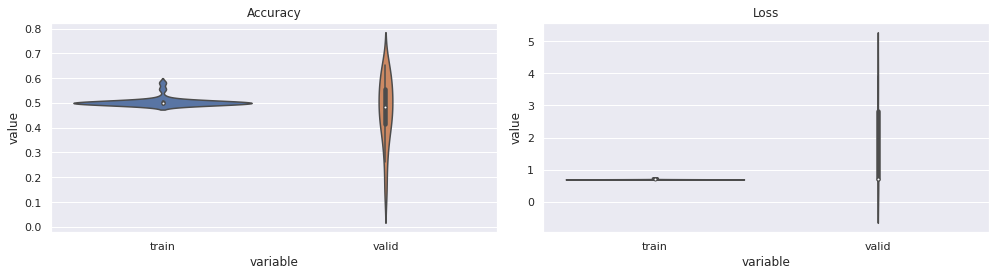

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

---
>The above shows violin plots. A violin plot is a method of plotting numeric data. It is similar to a box plot, with the addition of a rotated kernel density plot on each side. Violin plots are similar to box plots, except that they also show the probability density of the data at different values, usually smoothed by a kernel density estimator.

> We can observe that the validation accuracy distribution is more around the 0.55..

---

In [ ]:
yhat_valid = model.predict_classes(validation_generator)
scikitplot.metrics.plot_confusion_matrix(np.argmax(validation_generator, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(validation_generator, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [3]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/IITB_assignments/AML_project/Machine Learning/gender_recognition/dataset_gender/model_gender.h5')
model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 150, 150, 64)      256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       73856  

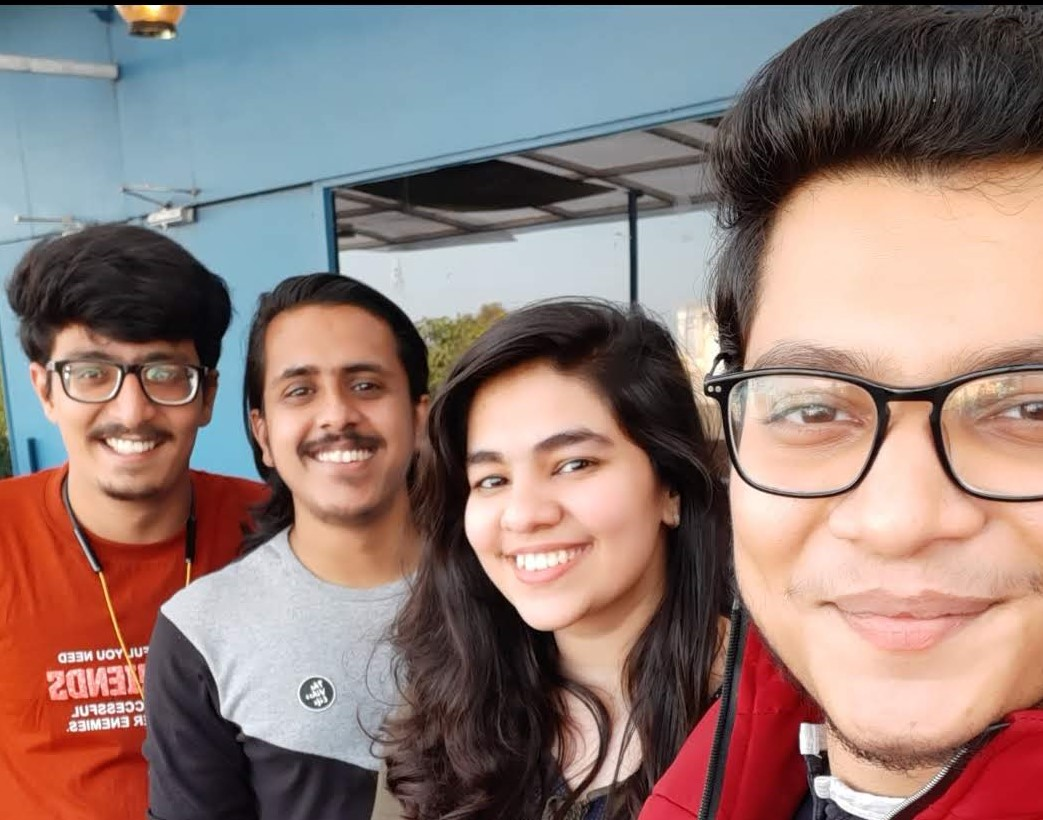

In [13]:
import cv2
from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

img = cv2.imread('/content/gdrive/My Drive/IITB_assignments/AML_project/Machine Learning/gender_recognition/dataset_gender/group1.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

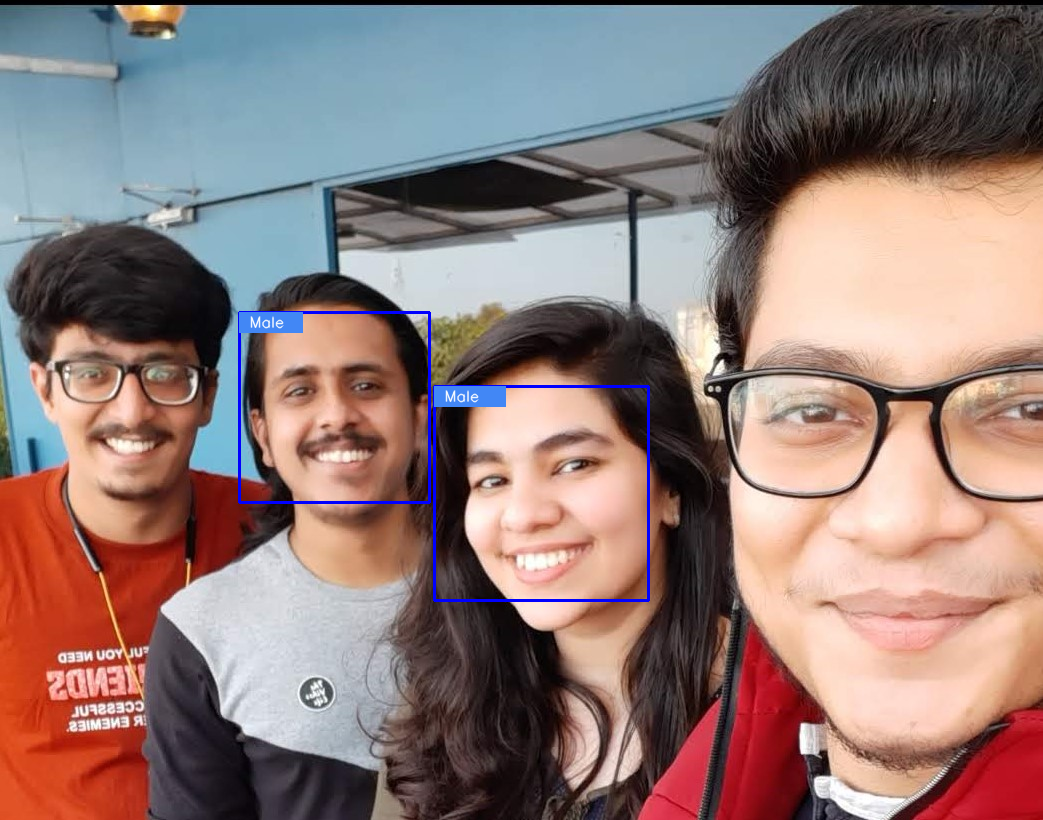

In [14]:
from google.colab.patches import cv2_imshow
import numpy as np
faces = face_cascade.detectMultiScale(img, 1.3, 5)
for (x,y,w,h) in faces:
    img1 = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.rectangle(img, (x, y), (x+w//3, y+20), (245, 135, 66), -1)
    roi_gray_neutral = gray_img[y:y+h, x:x+w]
    roi_gray_neutral = cv2.resize(roi_gray_neutral ,(150,150))
    image = roi_gray_neutral.reshape((1, 150, 150, 1))
    image = image/255
    prediction = np.argmax(model.predict(image))
    label = ['Female', 'Male']
    state = label[prediction]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(state),(x+10,y+15), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
cv2_imshow(img)